# Machine Learning API

> ICDSS Machine Learning Workshop Series: Coding Models on `scikit-learn`, `keras` & `fbprophet`

* [Pipeline](#pipeline)
    * [Preprocessing](#pipe:preprocessing)
    * [Estimation](#pipe:estimation)
        * [Supervised Learning](#pipe:supervised-learning)
        * [Unsupervised Learning](#pipe:unsupervised-learning)
    * [Evaluation](#pipe:evaluation)
* [`scikit-learn`](#scikit-learn)
    * [Preprocessing](#sk:preprocessing)
    * [Estimation](#sk:estimation)
        * [Regression](#sk:regression)
        * [Classification](#sk:classification)
    * [Model Selection](#sk:model-selection)
        * [Hyperparameters](#sk:hyperparameters)
        * [`GridSearchCV`](#sk:GridSearchCV)
    * [Pipeline](#sk:pipeline)
* [`keras`](#keras)
    * [Dense](#keras:dense)
        * [Iris](#keras:iris)
    * [CNN](#keras:cnn)
        * [Fashion MNIST](#keras:fashion-mnist)
    * [LSTM](#keras:lstm)
        * [President Trump Generator](#keras:president-trump-generator)
* [`fbprophet`](#fbprophet)
    * [Bitcoin Capital Market](#fbprophet:bitcoin-capital-market)

## Pipeline <a class="anchor" id="pipeline"></a>

<img src="assets/Pipeline.png" alt="Drawing" style="width: 750px;"/>

In [1]:
%reset -f

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-muted')

from sklearn import datasets

### Preprocessing <a class="anchor" id="pipe:preprocessing"></a>

In [2]:
class Preprocessor:
    """Generic `preprocessing` transformer."""
    
    def __init__(self, **hyperparameters):
        """Initialise Hyperparameters"""
        raise NotImplementedError
    
    def fit(self, X_train):
        """Set state of `preprocessor`."""
        raise NotImplementedError
    
    def transform(self, X):
        """Apply transformation."""
        raise NotImplementedError
    
    def fit_transform(self, X):
        """Reset state and apply transformer."""
        self.fit(X)
        return self.transform(X)

#### Principle Component Analysis (PCA)

In [3]:
class PCA:
    """Principle Component Analysis."""
    
    def __init__(self, n_components=2):
        """Contructor.
        
        Parameters
        ----------
        n_comps: int
            Number of principle components
        """
        self.n_comps = n_components
        self.mu = None
        self.U = None
        self._fitted = False
    
    def fit(self, X):
        """Fit PCA according to `X.cov()`.
        
        Parameters
        ----------
        X: numpy.ndarray
            Features matrix
        Returns
        -------
        array: numpy.ndarray
            Transformed features matrix
        """
        self.D, N = X.shape
        self.mu = X.mean(axis=1).reshape(-1, 1)
        # center data
        A = X - self.mu
        # covariance matrix
        S = (1 / N) * np.dot(A.T, A)
        # eigendecomposition
        _l, _v = np.linalg.eig(S)
        _l = np.real(_l)
        _v = np.real(_v)
        # short eigenvalues
        _indexes = np.argsort(_l)[::-1]
        # sorted eigenvalues and eigenvectors
        l, v = _l[_indexes], _v[:, _indexes]
        # eigenvalues
        V = v[:, :self.n_comps]
        # unnormalised transformer
        _U = np.dot(A, V)
        # transformation matrix
        self.U = _U / np.apply_along_axis(np.linalg.norm, 0, _U)
        # unnormalised transformed features
        W = np.dot(self.U.T, A)
        # data statistics
        self.W_mu = np.mean(W, axis=1)
        self.W_std = np.std(W, axis=1)

        self._fitted = True

        return self

    def transform(self, X):
        """Transform `X` by projecting it to PCA feature space.
        
        Parameters
        ----------
        X: numpy.ndarray
            Features matrix
        Returns
        -------
        array: numpy.ndarray
            Transformed features matrix
        """
        if not self._fitted:
            raise AssertionError('Not fitted yet.')
        # centered data
        Phi = X - self.mu
        # unnormalised transformed features
        W = np.dot(self.U.T, Phi)

        return ((W.T - self.W_mu) / self.W_std).T
    
    def fit_transform(self, X):
        """Fit PCA according to `X.cov()`
        and then transform `X` by
        projecting it to PCA feature space.
        
        Parameters
        ----------
        X: numpy.ndarray
            Features matrix
        Returns
        -------
        array: numpy.ndarray
            Transformed features matrix
        """
        self.fit(X)
        return self.transform(X)

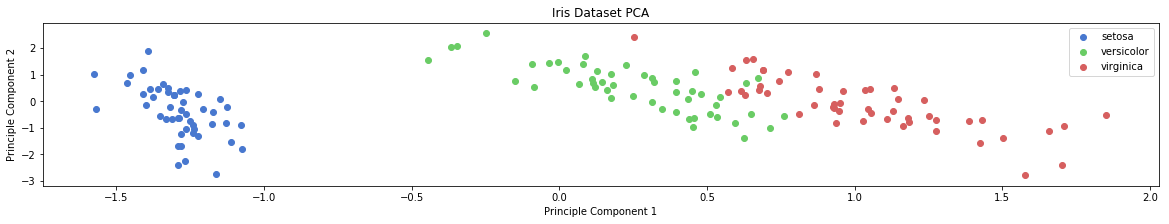

In [4]:
# preprocessor
pca = PCA(n_components=2)

# fetch data
iris = datasets.load_iris()
# supervised-learning data
X, y = iris.data, iris.target
# transformed data
X_transform = pca.fit_transform(X.T)

_, ax = plt.subplots(figsize=(20.0, 3.0))
for i in range(iris.target.max() + 1):
    I = iris.target == i
    ax.scatter(X_transform[0, I], X_transform[1, I], label=iris.target_names[i])
    ax.set_title('Iris Dataset PCA')
    ax.set_xlabel('Principle Component 1')
    ax.set_ylabel('Principle Component 2')
ax.legend();

#### `challenge` QuadraticFeatures

Code the transformation $\mathcal{G}$ such that:

$$\mathcal{G}: \mathbb{R}^{2} \rightarrow \mathbb{R}^{6}$$

according to the mapping:

$$\begin{bmatrix}x_{1} & x_{2}\end{bmatrix} \mapsto \begin{bmatrix}1 & x_{1} & x_{2} & x_{1}x_{2} & x_{1}^{2} & x_{2}^{2}\end{bmatrix}$$

In [5]:
class QuadraticFeatures:
    """Generate Quadratic features."""
    
    def fit(self, X_train):
        """Set state of `preprocessor`."""
        pass
        return self
    
    def transform(self, X):
        """Apply transformation."""
        # get dimensions
        N, D = X.shape
        # check number of input features
        assert(D==2)
        
        # get x_{1} column
        x_1 = X[:, 0]
        # get x_{2} column
        x_2 = X[:, 1]
        
        # initialise output matrix
        out = np.empty(shape=(N, 6))
        # column 1: constant
        out[:, 0] = 1
        # column 2: x_{1}
        out[:, 1] = x_1
        # column 3: x_{2}
        out[:, 2] = x_2
        # column 4: x_{1}x_{2}
        out[:, 3] = x_1 * x_2
        # column 5: x_{1}^{2}
        out[:, 4] = x_1**2
        # column 6: x_{2}^{2}
        out[:, 5] = x_2**2
        
        return out
    
    def fit_transform(self, X):
        """Reset state and apply transformer."""
        self.fit(X)
        return self.transform(X)

##### Unit Test for `QuadraticFeatures`

In [6]:
# unit test function
assert (QuadraticFeatures().fit_transform(np.array([[1, 2],
                                                    [3, 4]])) == np.array([[ 1.,  1.,  2.,  2.,  1.,  4.],
                                                                           [ 1.,  3.,  4., 12.,  9., 16.]])).all(), "Wrong implementation, try again!"
'Well Done!'

'Well Done!'

### Estimation <a class="anchor" id="pipe:estimation"></a>

In [7]:
class Estimator:
    """Generic `estimator` class."""
    
    def __init__(self, **hyperparameters):
        """Initialise Hyperparameters"""
        raise NotImplementedError
    
    def fit(self, X, y):
        """Train model."""
        return self
    
    def predict(self, X):
        """Forward/Inference pass."""
        return y_hat
    
    def score(self, X, y):
        """Performance results."""
        y_hat = self.predict(X)
        return self._loss(y, y_hat)
    
    def _loss(self, y, y_hat):
        """Objective function for scoring."""
        return L(y, y_hat)

#### `challenge` Linear Regression

Code the estimator $\mathcal{F}$ such that:

$$\mathbf{y} = \mathbf{X} * \mathbf{w}_{MLE}$$

for the Maximum Likelihood estimation weights parameters:

$$\mathbf{w}_{MLE} = (\mathbf{X}^{T} \mathbf{X})^{-1} * \mathbf{X}^{T} * \mathbf{y}$$

In [8]:
class LinearRegression:
    """Linear Regression `estimator` class."""
    
    def __init__(self, dimensionality):
        """Initialise Hyperparameters"""
        self.dimensionality = dimensionality
        self.w_mle = np.random.randn(self.dimensionality, 1)
    
    def fit(self, X, y):
        """Train model."""
        self.w_mle = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), y)
        return self
    
    def predict(self, X):
        """Forward/Inference pass."""
        y_hat = np.dot(X, self.w_mle)
        return y_hat
    
    def score(self, X, y):
        """Performance results."""
        y_hat = self.predict(X)
        return self._loss(y, y_hat)
    
    def _loss(self, y, y_hat):
        """Objective function for scoring."""
        return ((y - y_hat) ** 2).mean(axis=None)

##### Unit Test for `LinearRegression`

In [9]:
# dummy data
X, y = np.array([[1., 2.], [1., 3.], [1., 7.]]), np.array([2., 3., 7.])
# input dimensions
N, D = X.shape
# estimator: init & fit
lr = LinearRegression(dimensionality=D).fit(X, y)

# unit test function
assert np.isclose(lr.predict(X), y).all(), 'Wrong implementation, try again!'
'Well Done!'

'Well Done!'

## `scikit-learn` <a class="anchor" id="scikit-learn"></a>

### Preprocessing <a class="anchor" id="sk:preprocessing"></a>

In [10]:
%reset -f

import numpy as np
import pandas as pd
import sklearn
import sklearn.ensemble
import sklearn.neural_network
import sklearn.decomposition

from sklearn import datasets

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-muted')

import warnings
warnings.filterwarnings('ignore')

np.random.seed(0)

#### Principle Component Analysis <a class="anchor" id="sk:pca"></a>

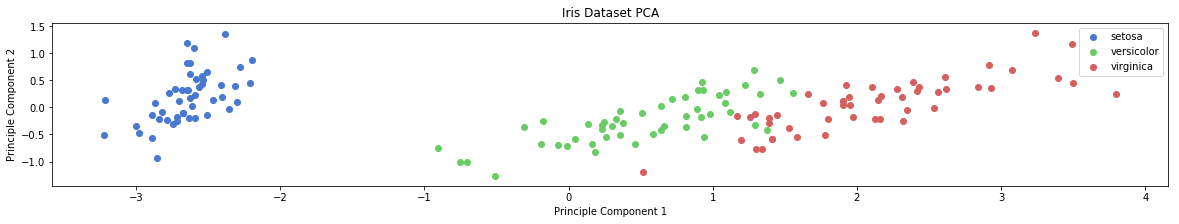

In [11]:
# preprocessor
pca = sklearn.decomposition.PCA(n_components=2)

# fetch data
iris = datasets.load_iris()
# supervised-learning data
X, y = iris.data, iris.target
# transformed data
X_transform = pca.fit_transform(X)

_, ax = plt.subplots(figsize=(20.0, 3.0))
for i in range(iris.target.max() + 1):
    I = iris.target == i
    ax.scatter(X_transform[I, 0], X_transform[I, 1], label=iris.target_names[i])
    ax.set_title('Iris Dataset PCA')
    ax.set_xlabel('Principle Component 1')
    ax.set_ylabel('Principle Component 2')
ax.legend();

### Estimation <a class="anchor" id="sk:estimation"></a>

<img src="assets/ml_map.png" alt="Drawing" style="width: 750px;"/>

### Regression <a class="anchor" id="sk:regression"></a>

Let's try to model a continous function:

$$f(x) = x^{3} - 0.4x^{2} - x + 0.3 + \epsilon, \quad x \in [-1, 1] \text{ and } \epsilon \sim \mathcal{N}(0, 0.05)$$

In [12]:
# fetch data
x = np.linspace(-1, 1, 500)
# targets
y = (x**3 - 0.4*x**2 - x + 0.3) + np.random.normal(0, 0.01, len(x))
# features matrix
X = x.reshape(-1, 1)

#### API

[Score] Gradient Boosting Tree Regressor: 0.992
[Score] Support Vector Machine Regressor: 0.960
[Score] Ridge Regressor: 0.587
[Score] K-Nearest Neighbors Regressor: 0.999
[Score] Multi-Layer Perceptron Regressor: 0.686


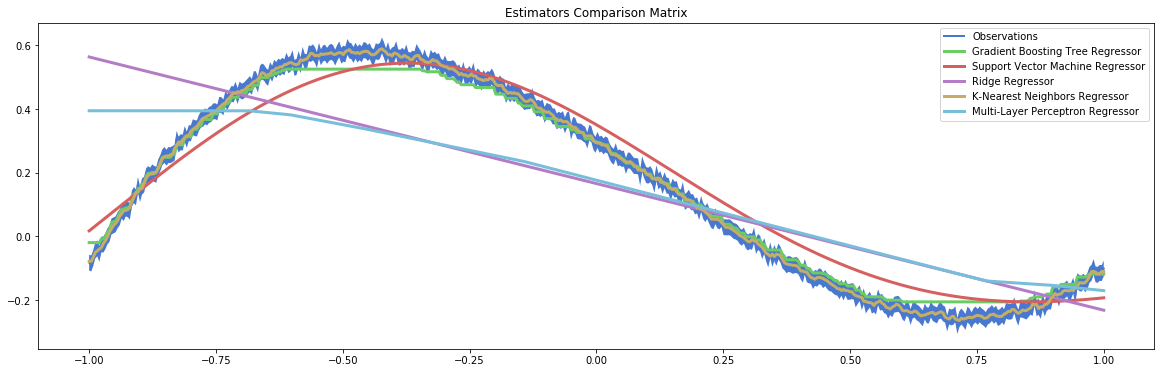

In [13]:
# initialize figure
_, ax = plt.subplots(figsize=(20.0, 6.0))
# true data
ax.plot(x, y, label='Observations', lw=2)
ax.fill_between(x, y-0.025, y+0.025)

## (1) INIT - set hyperparameters
estimators = [(sklearn.ensemble.GradientBoostingRegressor(n_estimators=25), 'Gradient Boosting Tree Regressor'),
              (sklearn.svm.SVR(C=1.0, kernel='rbf'), 'Support Vector Machine Regressor'),
              (sklearn.linear_model.Ridge(alpha=0.5), 'Ridge Regressor'),
              (sklearn.neighbors.KNeighborsRegressor(n_neighbors=3), 'K-Nearest Neighbors Regressor'),
              (sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(15,), activation='relu'), 'Multi-Layer Perceptron Regressor')
             ]

for model, name in estimators:
    ## (2) FIT - train model
    model.fit(X, y)
    ## (3) PREDICT - make predictions
    y_hat = model.predict(X)
    ## (4) SCORE - evaluate model
    score = model.score(X, y)
    
    print('[Score] %s: %.3f' % (name, score))
    # figure settings
    ax.plot(x, y_hat, label=name, lw=3)

ax.set_title('Estimators Comparison Matrix')
ax.legend();

#### Support Vector Machine Regressor

##### Linear Features

$f(x)$ is a highly non-linear function (cubic) and therefore it cannot be adequately modelled by a linear estimator,
nonetheless we will fit a `Linear SVM Regressor` and ascess its performance (visually).

[Score] Linear SVM: 0.535


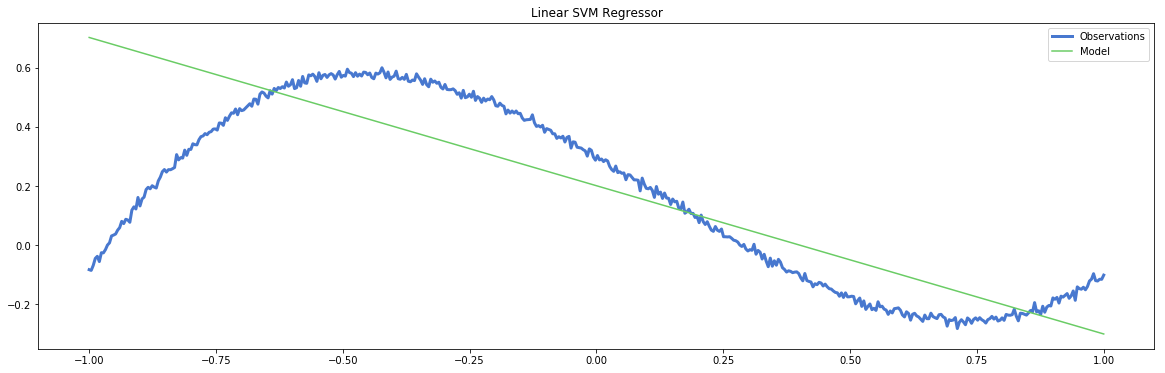

In [14]:
# initialize figure
_, ax = plt.subplots(figsize=(20.0, 6.0))
# true data
ax.plot(x, y, lw=3, label='Observations')

## (1) INIT
svr = sklearn.svm.SVR(C=1.0, kernel='linear')
## (2) FIT
svr.fit(X, y)
## (3) PREDICT
y_hat = svr.predict(X)
## (4) SCORE
score = svr.score(X, y)
print('[Score] %s: %.3f' % ('Linear SVM', score))

# figure settings
ax.plot(x, y_hat, label='Model')
ax.set_title('Linear SVM Regressor')
ax.legend();

##### Cubic Features

[Score] Linear SVM with Cubic Features: 0.960


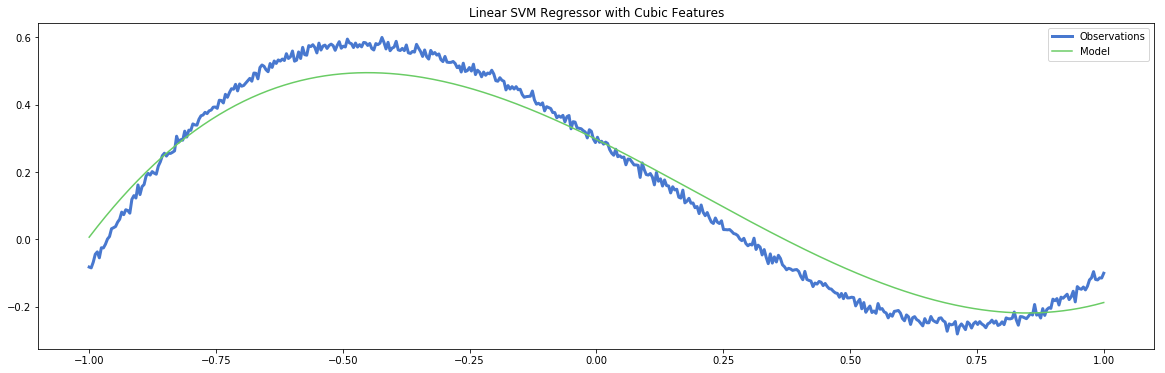

In [15]:
# preprocessor
poly = sklearn.preprocessing.PolynomialFeatures(degree=3)
# generate cubic features
X_transform = poly.fit_transform(X)

##### REPEAT THE SAME, X -> X_transform #####

# initialize figure
_, ax = plt.subplots(figsize=(20.0, 6.0))
# true data
ax.plot(x, y, lw=3, label='Observations')

## (1) INIT
svr = sklearn.svm.SVR(C=1.0, kernel='linear')
## (2) FIT
svr.fit(X_transform, y) # X -> X_transform #
## (3) PREDICT
y_hat = svr.predict(X_transform)
## (4) SCORE
score = svr.score(X_transform, y)
print('[Score] %s: %.3f' % ('Linear SVM with Cubic Features', score))

# figure settings
ax.plot(x, y_hat, label='Model')
ax.set_title('Linear SVM Regressor with Cubic Features')
ax.legend();

### Classification <a class="anchor" id="sk:classification"></a>

### Model Selection <a class="anchor" id="sk:model-selection"></a>

#### Hyperparameters <a class="anchor" id="sk:hyperparameters"></a>

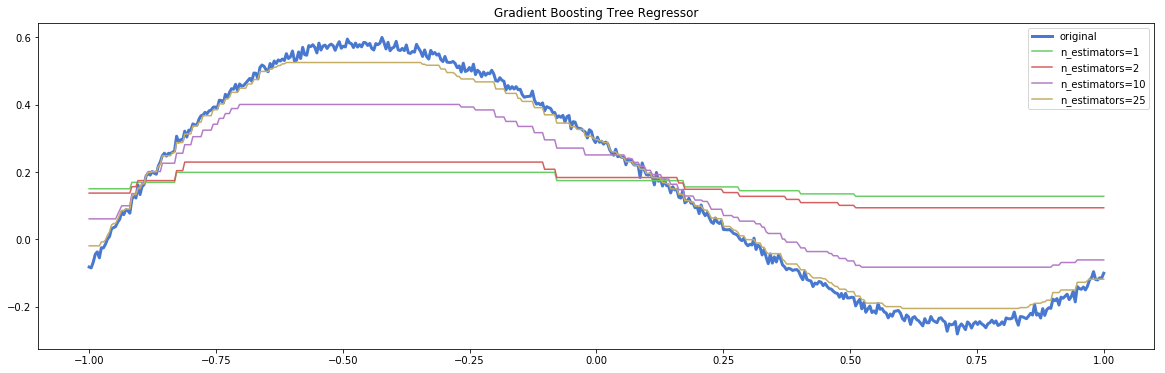

In [16]:
# initialize figure
_, ax = plt.subplots(figsize=(20.0, 6.0))
# true data
ax.plot(x, y, label='original', lw=3)

# parameters
n_estimators_params = [1, 2, 10, 25]

for n_estimators in n_estimators_params:
    # initialize estimator
    gbr = sklearn.ensemble.GradientBoostingRegressor(n_estimators=n_estimators).fit(X, y)
    # prediction
    y_hat = gbr.predict(X)
    
    # figure settings
    ax.plot(x, y_hat, label='n_estimators=%s' % n_estimators)
    ax.set_title('Gradient Boosting Tree Regressor')
ax.legend();

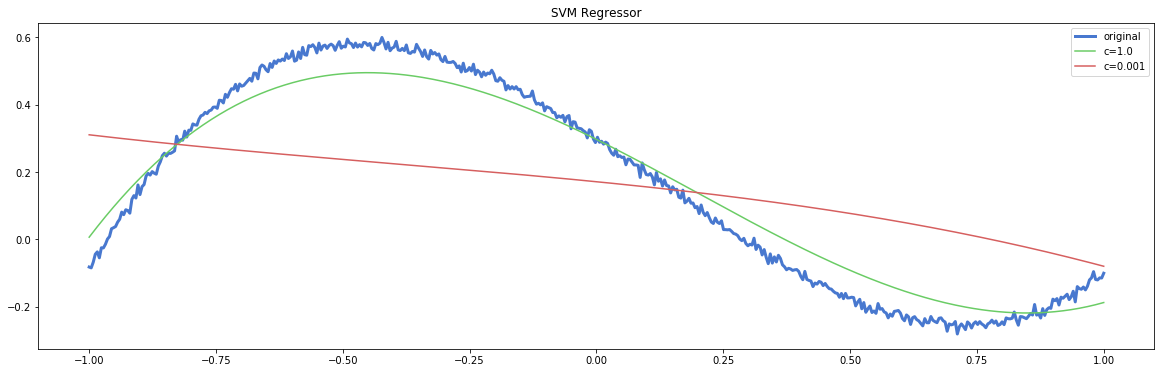

In [17]:
# preprocessor
poly = sklearn.preprocessing.PolynomialFeatures(degree=3)
# generate cubic features
X_transform = poly.fit_transform(X)

# initialize figure
_, ax = plt.subplots(figsize=(20.0, 6.0))
# true data
ax.plot(x, y, label='original', lw=3)

# parameters
c_params = [1.0, 0.001]

for c in c_params:
    # initialize estimator
    svr = sklearn.svm.SVR(C=c, kernel='linear').fit(X_transform, y)
    # prediction
    y_hat = svr.predict(X_transform)
    
    # figure settings
    ax.plot(x, y_hat, label='c=%s' % c)
    ax.set_title('SVM Regressor')
ax.legend();

#### `GridSearchCV` <a class="anchor" id="sk:GridSearchCV"></a>

[Score] Best Random Forest Classifier: 0.984


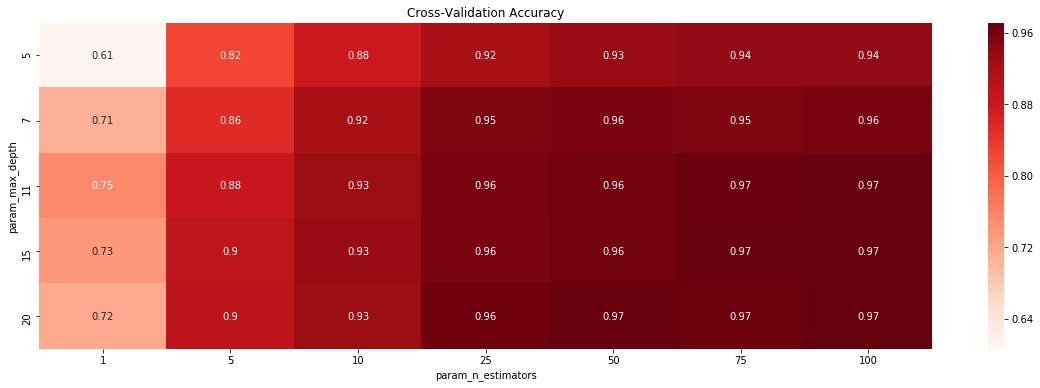

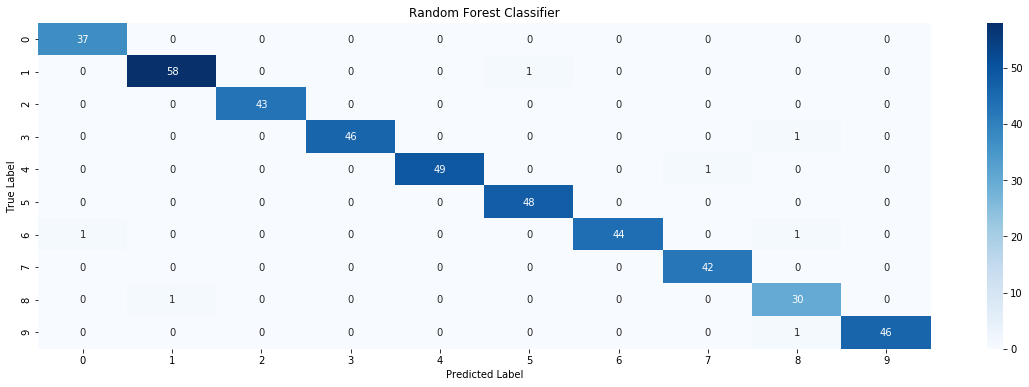

In [18]:
# fetch data
digits = datasets.load_digits()
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(digits.data,
                                                                            digits.target,
                                                                            test_size=0.25)

# estimator hyperparameters grid
param_grid = {'n_estimators': [1, 5, 10, 25, 50, 75, 100],
              'max_depth': [5, 7, 11, 15, 20]
             }

## (1) INIT - set hyperparameters **RANGES**, not single values
search = sklearn.model_selection.GridSearchCV(sklearn.ensemble.RandomForestClassifier(), param_grid)

## (2) FIT
search.fit(X_train, y_train)

## (**) REPORT - cross validation results
results = pd.DataFrame(search.cv_results_).set_index(['param_' + key for key in param_grid.keys()])
mean_test_score = results['mean_test_score'].unstack(0)
# figure settings
_, ax = plt.subplots(figsize=(20.0, 6.0))
sns.heatmap(mean_test_score, annot=True, cmap=plt.cm.Reds, ax=ax)
ax.set_title('Cross-Validation Accuracy')

## (**) SELECT - pick the best model
model = search.best_estimator_

## (3) PREDICT
y_hat = model.predict(X_test)

## (4) SCORE
score = model.score(X_test, y_test)
print('[Score] %s: %.3f' % ('Best Random Forest Classifier', score))

# confusion matrix
cm = sklearn.metrics.confusion_matrix(y_test, y_hat)

# figure settings
_, ax = plt.subplots(figsize=(20.0, 6.0))
sns.heatmap(cm, ax=ax, annot=True, cmap=plt.cm.Blues)
ax.set_title('Random Forest Classifier')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label');

### Pipeline <a class="anchor" id="sk:pipeline"></a>

## `keras` <a class="anchor" id="keras"></a>

### Iris Dataset <a class="anchor" id="keras:iris"></a>

In [19]:
%reset -f

from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Activation
from keras.optimizers import RMSprop
from keras.utils import to_categorical

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


#### Data & Preprocessing

In [20]:
# fetch data
iris = datasets.load_iris()

# split to train/test datasets
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target)
# one-hot encode categorical output
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

# matrix shapes
N_train, D = X_train.shape
N_test, _ = X_test.shape
_, M = y_train_one_hot.shape

#### Feedforward Neural Network

In [21]:
# input layer
X = Input(shape=(D,), name="X")

# Convolution Layer
A1 = Dense(16, name="A1")(X)
# Non-Linearity
Z1 = Activation("relu", name="Z1")(A1)
# Affine Layer
A2 = Dense(M, name="A2")(Z1)
# Multi-Class Classification
Y = Activation("softmax", name="Y")(A2)

# Define Graph
model = Model(inputs=X, outputs=Y)
# Compile Graph
model.compile(optimizer=RMSprop(lr=0.04),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Computational Graph Summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X (InputLayer)               (None, 4)                 0         
_________________________________________________________________
A1 (Dense)                   (None, 16)                80        
_________________________________________________________________
Z1 (Activation)              (None, 16)                0         
_________________________________________________________________
A2 (Dense)                   (None, 3)                 51        
_________________________________________________________________
Y (Activation)               (None, 3)                 0         
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [22]:
# model training
history = model.fit(X_train, y_train_one_hot, epochs=100, validation_split=0.25, verbose=0)

#### Evaluation

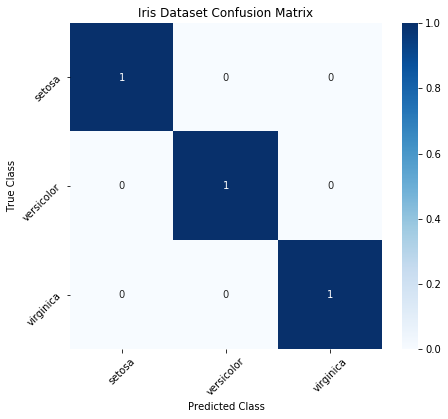

In [23]:
y_hat_one_hot = model.predict(X_test)

# one-hot-encoded to raw data
y_hat = np.argmax(y_hat_one_hot, axis=1)

# confusion matrix
cm = confusion_matrix(y_test, y_hat)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
_, ax = plt.subplots(figsize=(7.0, 6.0))
sns.heatmap(cm_norm, annot=True, cmap=plt.cm.Blues, ax=ax)
ax.set_xticklabels(iris.target_names, rotation=45)
ax.set_yticklabels(iris.target_names, rotation=45)
ax.set_title('Iris Dataset Confusion Matrix')
ax.set_xlabel('Predicted Class')
ax.set_ylabel('True Class');

### Fashion MNIST <a class="anchor" id="keras:fashion-mnist"></a>

In [24]:
%reset -f

from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.optimizers import RMSprop
from keras.utils import to_categorical

from keras.datasets import fashion_mnist

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

np.random.seed(0)

#### Data & Preprocessing

In [25]:
import pickle

# fetch data
(X_train_raw, y_train), (X_test_raw, y_test) = pickle.load(open('data/fashion-mnist/fashion-mnist.pkl', 'rb'))
## ORIGINAL IMPLEMNTATION
# (X_train_raw, y_train), (X_test_raw, y_test) = fashion_mnist.load_data()

# one-hot encode categorical output
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

# tensor shape
N_train, h, w = X_train_raw.shape
N_test, _, _ = X_test_raw.shape
_, M = y_train_one_hot.shape

# convert raw pixels to tensors
X_train = X_train_raw.reshape(-1, h, w, 1)
X_test = X_test_raw.reshape(-1, h, w, 1)

#### Convolutional Neural Network

In [26]:
# input layer: shape=(height, width, number of channels)
X = Input(shape=(h, w, 1), name="X")

# Convolution Layer
CONV1 = Conv2D(filters=32, kernel_size=(3, 3), activation="relu", name="CONV1")(X)
# Max Pooling Layer
POOL1 = MaxPooling2D(pool_size=(2, 2), name="POOL1")(CONV1)
# Convolution Layer
CONV2 = Conv2D(filters=32, kernel_size=(3, 3), activation="relu", name="CONV2")(POOL1)
# Max Pooling Layer
POOL2 = MaxPooling2D(pool_size=(2, 2), name="POOL2")(CONV2)
# Convolution Layer
CONV3 = Conv2D(filters=64, kernel_size=(3, 3), activation="relu", name="CONV3")(POOL2)
# Max Pooling Layer
POOL3 = MaxPooling2D(pool_size=(2, 2), name="POOL3")(CONV3)
# Convert 3D feature map to 1D
FLAT = Flatten()(POOL3)
# Fully Connected Layer
FC1 = Dense(units=64, name="FC1")(FLAT)
# Dropout
DROP = Dropout(rate=0.5, name="DROP")(FC1)
# Multi-Class Classification Output Layer
Y = Dense(M, activation="softmax", name="Y")(DROP)

# Define Graph
model = Model(inputs=X, outputs=Y)
# Compile Graph
model.compile(optimizer=RMSprop(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Computational Graph Summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X (InputLayer)               (None, 28, 28, 1)         0         
_________________________________________________________________
CONV1 (Conv2D)               (None, 26, 26, 32)        320       
_________________________________________________________________
POOL1 (MaxPooling2D)         (None, 13, 13, 32)        0         
_________________________________________________________________
CONV2 (Conv2D)               (None, 11, 11, 32)        9248      
_________________________________________________________________
POOL2 (MaxPooling2D)         (None, 5, 5, 32)          0         
_________________________________________________________________
CONV3 (Conv2D)               (None, 3, 3, 64)          18496     
_________________________________________________________________
POOL3 (MaxPooling2D)         (None, 1, 1, 64)          0         
__________

In [27]:
# model training
history = model.fit(X_train, y_train_one_hot, batch_size=128, epochs=3, validation_split=0.25)

Train on 45000 samples, validate on 15000 samples
Epoch 1/3
45000/45000 [==============================] - 33s 740us/step - loss: 1.1814 - acc: 0.6861 - val_loss: 0.5854 - val_acc: 0.7869
Epoch 2/3
45000/45000 [==============================] - 35s 777us/step - loss: 0.5427 - acc: 0.8107 - val_loss: 0.4507 - val_acc: 0.8380
Epoch 3/3
45000/45000 [==============================] - 34s 745us/step - loss: 0.4596 - acc: 0.8404 - val_loss: 0.4490 - val_acc: 0.8423


#### Evaluation

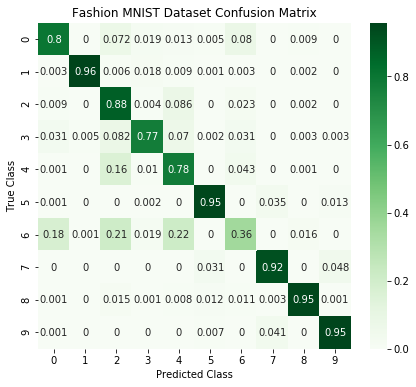

In [28]:
y_hat_one_hot = model.predict(X_test)

# one-hot-encoded to raw data
y_hat = np.argmax(y_hat_one_hot, axis=1)

# confusion matrix
cm = confusion_matrix(y_test, y_hat)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
_, ax = plt.subplots(figsize=(20.0, 6.0))
sns.heatmap(cm_norm, annot=True, cmap=plt.cm.Greens, ax=ax)
ax.set_title('Fashion MNIST Dataset Confusion Matrix')
ax.set_xlabel('Predicted Class')
ax.set_ylabel('True Class');

### President Trump Generator <a class="anchor" id="keras:president-trump-generator"></a>

In [29]:
%reset -f

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

from keras.datasets import fashion_mnist

import numpy as np

np.random.seed(0)

#### Data & Preprocessing

In [30]:
# fetch data
with open("data/trump/speeches.txt") as corpus_file:
    corpus = corpus_file.read()
print("Loaded a corpus of {0} characters".format(len(corpus)))
corpus_length = len(corpus)

# Get a unique identifier for each char in the corpus
# then make some dicts to ease encoding and decoding
chars = sorted(list(set(corpus)))
num_chars = len(chars)
encoding = {c: i for i, c in enumerate(chars)}
decoding = {i: c for i, c in enumerate(chars)}
print("Our corpus contains {0} unique characters.".format(num_chars))

# it slices, it dices, it makes julienned datasets!
# chop up our data into X and y, slice into roughly (num_chars / skip) overlapping 'sentences'
# of length sentence_length, and encode the chars
sentence_length = 50
skip = 1
X_data = []
y_data = []
for i in range (0, len(corpus) - sentence_length, skip):
    sentence = corpus[i:i + sentence_length]
    next_char = corpus[i + sentence_length]
    X_data.append([encoding[char] for char in sentence])
    y_data.append(encoding[next_char])

num_sentences = len(X_data)
print("Sliced our corpus into {0} sentences of length {1}".format(num_sentences, sentence_length))

# Vectorize our data and labels. We want everything in one-hot
# because smart data encoding cultivates phronesis and virtue.
print("Vectorizing X and y...")
X = np.zeros((num_sentences, sentence_length, num_chars), dtype=np.bool)
y = np.zeros((num_sentences, num_chars), dtype=np.bool)
for i, sentence in enumerate(X_data):
    for t, encoded_char in enumerate(sentence):
        X[i, t, encoded_char] = 1
    y[i, y_data[i]] = 1

# Double check our vectorized data before we sink hours into fitting a model
print("Sanity check y. Dimension: {0} # Sentences: {1} Characters in corpus: {2}".format(y.shape, num_sentences, len(chars)))
print("Sanity check X. Dimension: {0} Sentence length: {1}".format(X.shape, sentence_length))

Loaded a corpus of 132087 characters
Our corpus contains 86 unique characters.
Sliced our corpus into 132037 sentences of length 50
Vectorizing X and y...
Sanity check y. Dimension: (132037, 86) # Sentences: 132037 Characters in corpus: 86
Sanity check X. Dimension: (132037, 50, 86) Sentence length: 50


#### Recurrent Neural Network

In [31]:
model = Sequential()
model.add(LSTM(units=256, input_shape=(sentence_length, num_chars), name="LSTM"))
model.add(Dense(units=num_chars, activation="softmax", name="Y"))

# Compile Graph
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy')
# Computational Graph Summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM (LSTM)                  (None, 256)               351232    
_________________________________________________________________
Y (Dense)                    (None, 86)                22102     
Total params: 373,334
Trainable params: 373,334
Non-trainable params: 0
_________________________________________________________________


In [32]:
# remove this line to train the model again
if None:
    # Dump our model architecture to a file so we can load it elsewhere
    architecture = model.to_yaml()
    with open('models/trump.yaml', 'a') as model_file:
        model_file.write(architecture)

    # Set up checkpoints
    file_path="models/trump-weights-{epoch:02d}-{loss:.3f}.hdf5"
    checkpoint = ModelCheckpoint(file_path, monitor="loss", verbose=1, save_best_only=True, mode="min")
    callbacks = [checkpoint]

    # model training
    history = model.fit(X, y, epochs=30, batch_size=256, callbacks=callbacks)
else:
    # load weights from checkpoint
    model.load_weights("models/trump-weights-03-2.152.hdf5")

#### Helper Functions

In [33]:
def generate(seed_pattern):
    X = np.zeros((1, sentence_length, num_chars), dtype=np.bool)
    for i, character in enumerate(seed_pattern):
        X[0, i, encoding[character]] = 1

    generated_text = ""
    for i in range(10):
        prediction = np.argmax(model.predict(X, verbose=0))

        generated_text += decoding[prediction]

        activations = np.zeros((1, 1, num_chars), dtype=np.bool)
        activations[0, 0, prediction] = 1
        X = np.concatenate((X[:, 1:, :], activations), axis=1)

    return generated_text

def make_seed(seed_phrase=""):
    if seed_phrase:
        phrase_length = len(seed_phrase)
        pattern = ""
        for i in range (0, sentence_length):
            pattern += seed_phrase[i % phrase_length]
    else:
        seed = randint(0, corpus_length - sentence_length)
        pattern = corpus[seed:seed + sentence_length]

    return pattern

#### Evaluation

In [34]:
# seed letter
seed = "b"
# prediction
seed + generate(make_seed(seed))

'be the wall'

## `fbprophet` <a class="anchor" id="fbprophet"></a>

In [35]:
%reset -f

from fbprophet import Prophet

import pandas_datareader.data as web

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(0)

#### Data & Preprocessing

In [36]:
# fetch data
btc = web.DataReader("BCHARTS/KRAKENUSD", data_source="quandl").dropna()

# time-series DataFrame
df = pd.DataFrame(columns=["ds", "y"])
df["ds"] = btc.index
# market capital column
df["y"] = (btc["Close"] * btc["VolumeBTC"]).values

df.head()

,ds,y
0,2018-03-06,1.043163e+08
1,2018-03-05,5.664643e+07
2,2018-03-04,4.776662e+07
3,2018-03-03,5.650515e+07
4,2018-03-02,6.330346e+07


#### MAP Optimization and Hamiltonian Monte Carlo Inference

In [37]:
# define model
model = Prophet()

# train model
model.fit(df);

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


#### Evaluation

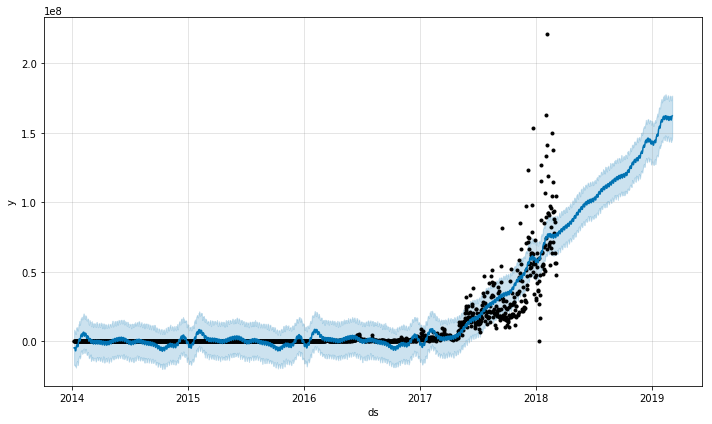

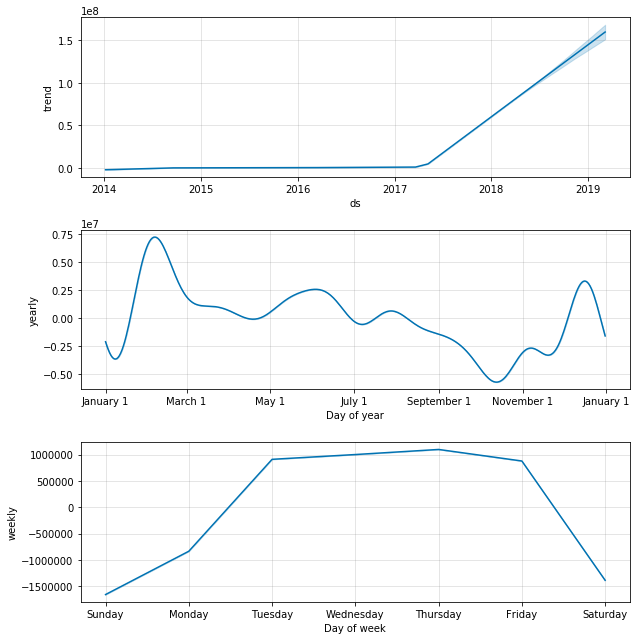

In [38]:

future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

# generate plots
model.plot(forecast);
model.plot_components(forecast);

## Disclaimer

Presentations are intended for educational purposes only and do not replace independent professional judgment.
Statements of fact and opinions expressed are those of the participants individually and,
unless expressly stated to the contrary, are not the opinion or position of the ICDSS, its cosponsors, or its committees.
The ICDSS does not endorse or approve, and assumes no responsibility for, the content,
accuracy or completeness of the information presented.
Attendees should note that sessions are video-recorded and may be published in various media, including print,
audio and video formats without further notice.